# 0. Introduction

This tutorial will introduce a different kind of cluster algorithm called *Density-based spatial clustering of applications with noise*, as known as **DBSCAN**. Different from the K-means where clusters are represented by a central vector, DBSCAN is a kind of *Density-based clustering* algorithm. It is called so because in such algorithm, the clusters are represented as areas with higher density than the rest of the areas. 

The tutorial would started with identify some of the K-means algorithm's weakness and how DBSCAN works better on them. Then it will lead step by step on how to build a 'toy-like' DBSCAN algorithm on 2D scale. 

Finally, we would implement the algorithm into a Twitter spatial analytics problem and compare the performance between DBSCAN and K-means.

Before we get started, we can import some of the packages we would like to use in this tutorial.


In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans, MiniBatchKMeans

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# 1. K-means algorithm's weakness

While K-means clustering is an very powerful way of making aggregation, there are some weakness lies in it.
First the K-means algorithm is highly depended on calculating the distance between each points. So it do not have the ability to identify any outliers, and what's worse, the outliers would influence the cluster of the algorithm. 

This would lead to another known problem to K-means. Since the algorithm is centroid-based, it works good with the clusters when they are convex shapes. However, when it leads to non-convex ones, the algorithm would generate results which are not really conprehensive. In the real data analysis, such result would not really helpful for us to understand the data.

Here is a live example showing how the K-means and DBSCAN running on a toy dataset. The dataset includes two moon-like clusters which are not convex clusters.

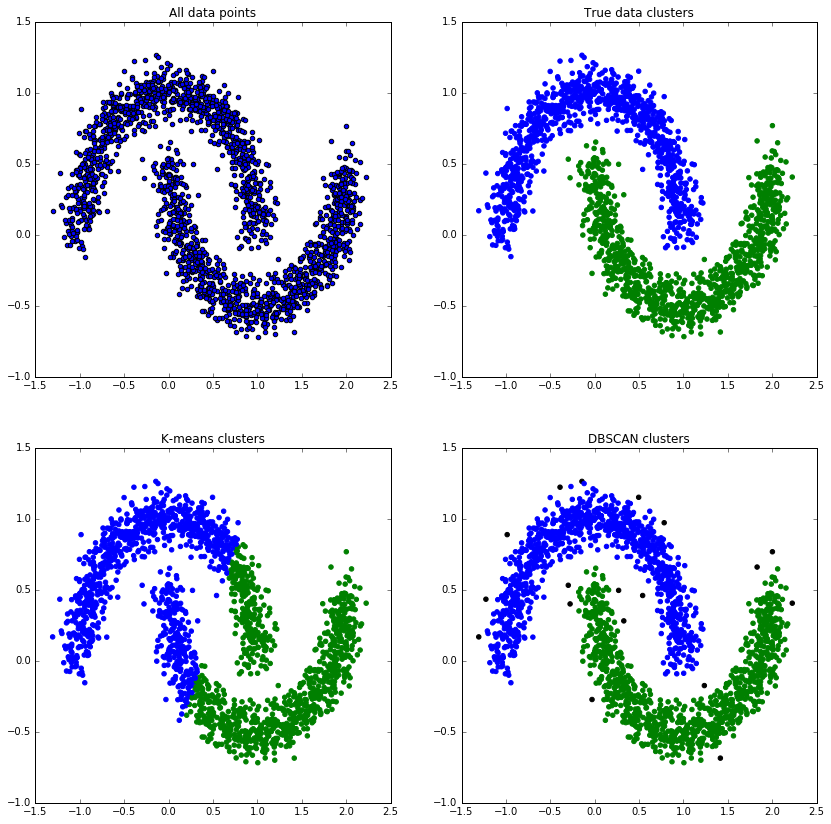

In [2]:
from sklearn import datasets
# Set random seed
np.random.seed(0)
# Build a random moon sample
sample_num = 2000
X, label = datasets.make_moons(n_samples= sample_num, noise= 0.1)
dfX = pd.DataFrame(X, columns=['x', 'y'])
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

dbscan = DBSCAN(eps=.1)
kmeans = KMeans(n_clusters=2)
dbscan_label = dbscan.fit_predict(dfX)
kmeans_label = kmeans.fit_predict(dfX)

# plot the charts
plt.figure(figsize=(14, 14))

plt.subplot(221)
plt.title('All data points')
plt.scatter(dfX.x, dfX.y)

plt.subplot(222)
plt.title('True data clusters')
plt.scatter(dfX.x, dfX.y, color=colors[label].tolist())

plt.subplot(223)
plt.title('K-means clusters')
plt.scatter(dfX.x, dfX.y, color=colors[kmeans_label].tolist())

plt.subplot(224)
plt.title('DBSCAN clusters')
plt.scatter(dfX.x, dfX.y, color=colors[dbscan_label].tolist())

plt.show()

In this diagram, upperleft side charts are all the data points for this dataset, we can see clearly the data should be divided into 2 parts. The true cluster is shown in the upperright diagram. It implies that only when the predicted clusters are close to the right side part, the cluster is helpful for our data analysis.

However, because of the natural of the K-means algorithm, When we run the K-means on this dataset, the result is not so satisfactory. The algorithm divided the datasets into two random parts and it did not capture the true information behind the scene.

On the contrary, in the right side of the K-means, DBSCAN successfully captures the right clusters and divided the datasets as what we wanted.

Why is that? That's something we would like to explain in the next part.

# 2. Density-based clustering

Different from the given number of centriods in K-means, DBSCAN works from a single point and connects to its **nearest neighbours**. Then iterate the process to link to each other to assemble a cluster. All the points that **cannot be reached** would then be taken as a noice point and drop.

Therefore the key part for DBSCAN lies in two arguments. They are the *minimal distances* which identify whether the point can be reached from any other points and the *number of nearest neighbours* which identify whether the point can be taken as a core point.

We can build our implementation of DBSCAN algorithm from here.


In [49]:
import math
class MyDBSCAN:
    def __init__(self, X, eps = 0.1, min_samples = 5):
        '''
        eps is the shortest distance
        min_sample is the minimal number of nearest neighbours required 
        Assume X is a pandas.Dataframe to simplify the problem here.
        Each row of X is a point in a 2D scale
        '''
        self.eps = eps
        self.min_samples = min_samples
        self.X = pd.DataFrame(X)
        self.num_of_points = self.X.shape[0]
        self.cluster = [False] * self.num_of_points
        
    def euclid_dist(self, a, b):
        '''
        Function used to calculate the Euclid distance between two 2D data points
        '''
        a = np.array(a)
        b = np.array(b)
        return np.linalg.norm(a-b)
    
    def is_neighbour(self, a, b):
        '''
        Function used to determine whether one point is in the shortest distance of the other
        '''
        return self.euclid_dist(a,b) < self.eps
    
    def region_query(self, p_id):
        '''
        Function to query the nearest neighbour ids of point p
        '''
        neighbours = []
        # The idea here is to check whether the other points are close enough to current point
        # If close enough, we may start to expand clusters from here
        for index in range(self.num_of_points):
            if self.is_neighbour(self.X.iloc[p_id], self.X.iloc[index]):
                neighbours.append(index)
        return neighbours
    def expand_cluster(self, p_id, cluster_id):
        '''
        Function to expand cluster from one point to its neighbours
        '''
        neighbours = self.region_query(p_id)
        # If the num of neighbours is less than the minimal numbers
        # We take it as a noise point
        if len(neighbours) < self.min_samples:
            self.cluster[p_id] = -1
            return False
        else:
            # Try to expand it to all possible neighbours
            # and neighbours of neighbours 
            self.cluster[p_id] = cluster_id
            for neighbour_id in neighbours:
                self.cluster[neighbour_id] = cluster_id
            while len(neighbours) > 0:
                current_p = neighbours[0]
                results = self.region_query(current_p)
                if len(results) >= self.min_samples:
                    for i in range(len(results)):
                        result_p = results[i]
                        if self.cluster[result_p] == -1 or self.cluster[result_p] == False:
                            if self.cluster[result_p] == False:
                                neighbours.append(result_p)
                            self.cluster[result_p] = cluster_id
                # pop the first point out
                neighbours = neighbours[1:]
                    
            return True
                    
    def fit_predict(self):
        '''
        Function to assemble everything and cluster the data points
        '''
        cluster_id = 1
        for p_id in range(self.num_of_points):
            if self.cluster[p_id] == False:
                if self.expand_cluster(p_id, cluster_id):
                    cluster_id += 1
        return self.cluster
    
        
        

Let's look into the implementation in the class. 
This simple implementation did not take efficiency into consideration but care more in describing the idea of the algorithm. This class only have one way of evaluating the distance, which is the Euclid distance. The implementation is finished in `euclid_dist`. 
Then we can move the check how the algorithm is working.

The idea of how this algorithm cluster is in the following steps:
1. Find a point which not yet been clustered, give it an arbitary cluster label
2. Find all its neighbours in a given area, which is the circle with the eps as its radius
  1. If cannot find any neighbours, label the point as noise point now. They may belongs to other clusters in the future.
  2. If find, put all the neighbours into a queue, and give them the same cluster label as the point
  3. Expand any neighbours' neighbour points which are not been labeled or labeled as noise before into the neighbours queue
  4. Iterate until no new neighbours can be found. Mark it the end of a cluster generation
    
3. If there still are points not been labelled, repeat from step 1. Otherwise, finish the algorithm.

A graphic description is listed here: 

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/640px-DBSCAN-Illustration.svg.png "DBSCAN Illustration wikipedia")

[Source: Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/640px-DBSCAN-Illustration.svg.png)

In this chart, A is where the point get started. It expanded to all red poins neighbours and currently trying to test whether they can expand to B and C. N is a noise point here since it can not been linked from any other point. This is exactly what I do in the implementation.

In my implementation, the `region_query` is used to find all the neighbours to a point. Then `expand_cluster` expanded current point to all its possible neighbours and neighbours' neighbours and so on. Each time it investigate one point then pop it out. Noise point is labeled as -1 in my implementation and the cluster lebal started at 1.

Since the cluster is not expanded from a center, it does not requires the data set in convex shape.

Now we can try to use my implementation to a sample dataset and verify its correctness:

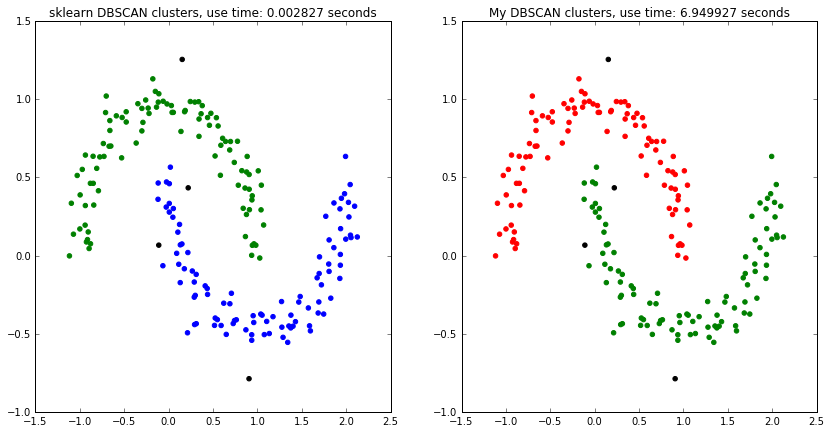

In [63]:
import time

# plot the charts
sample_num = 200
X, label = datasets.make_moons(n_samples= sample_num, noise= 0.1)
dfX = pd.DataFrame(X, columns=['x', 'y'])

dbscan = DBSCAN(eps=.2, min_samples=5)
mydbscan = MyDBSCAN(dfX, eps=0.2, min_samples = 5)
t0 = time.time()
dbscan_label = dbscan.fit_predict(dfX)
t_dbscan = time.time() - t0
t0 = time.time()
mydbscan_label = mydbscan.fit_predict()
t_mydbscan = time.time() - t0

plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.title('sklearn DBSCAN clusters, use time: %5f seconds' %t_dbscan)
plt.scatter(dfX.x, dfX.y, color=colors[dbscan_label].tolist())

plt.subplot(122)
plt.title('My DBSCAN clusters, use time: %5f seconds' %t_mydbscan)
plt.scatter(dfX.x, dfX.y, color=colors[mydbscan_label].tolist())
plt.show()


We can see clearly in these two charts, my implementation resulted in the same cluster label as the sklearn package algorithm. However, my class is much slower than the packaged one. So to simplify the analytics, we would use the sklearn version to analyze the Twitter data. 

# 3. Twitter analytic

In this section we would investigate into approximate 70000 twitter location data points in San Francisco bay area. The dataset was fetched from the Twitter API and have been parsed to include only the latitude and longitude information. 
There are definitely a lot of aspects can be looked into in this dataset. However, in my implementation, I am only wondering how to cluster big 'Twitter Cities' from the input dataset. 

So I would use both K-means algorithm as well as the DBSCAN algorithm to cluster the dataset. Then plot them to compare which one is more descriptive in evaluation the requirements. Since the geolocation ploting can be another tutorial by itself, to simplify the question, I did not plot the points on a base map but use simple plot instead.

The map for this area is ploted here: 
![Screen Shot 2016-10-30 at 23.50.56](bayareamap.png)
[Source: Google Map](https://www.google.com/maps)

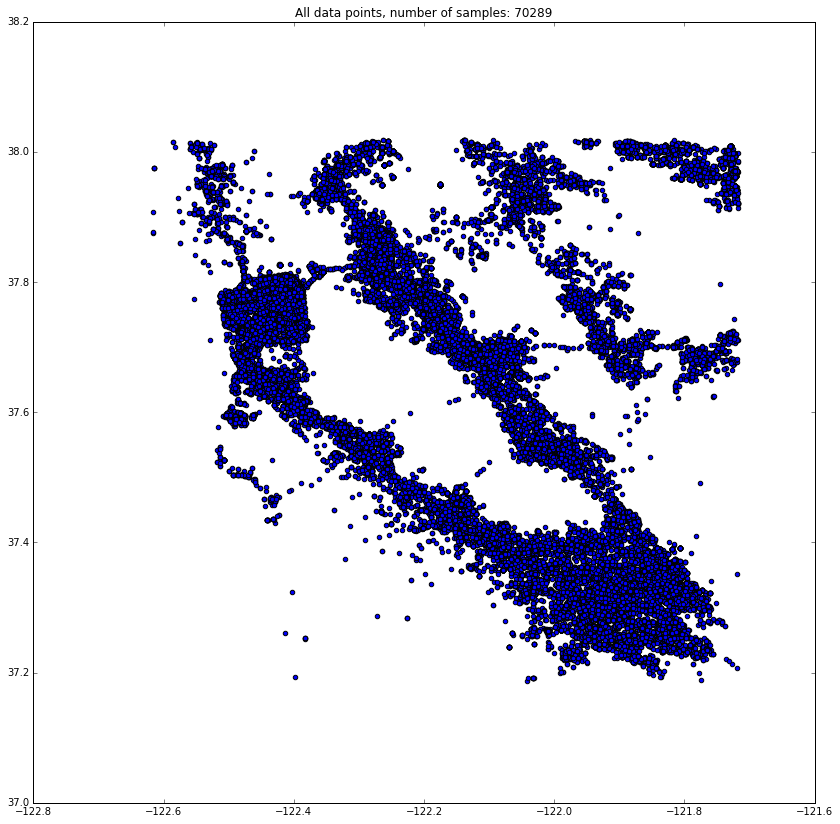

In [90]:
sample = pd.read_csv("bay_sample.csv")
plt.figure(figsize=(14, 14))
plt.title('All data points, number of samples: %d' %len(sample))
plt.scatter(sample.lng, sample.lat)
plt.show()

For anyone who does not really familiar with San Francisco bay area, the bay is surrounded by a lot of cities. Then mountains seperate the cities again. So in my analyzing, I would like to see people who enjoy sending twitter grouped together and show the cities boundry by the number of people twittering.

We can clearly see from the previous chart that the tweets draws almost precisely the city map around the bay. Now lets check how the k-means and the DBSCAN cluster them.

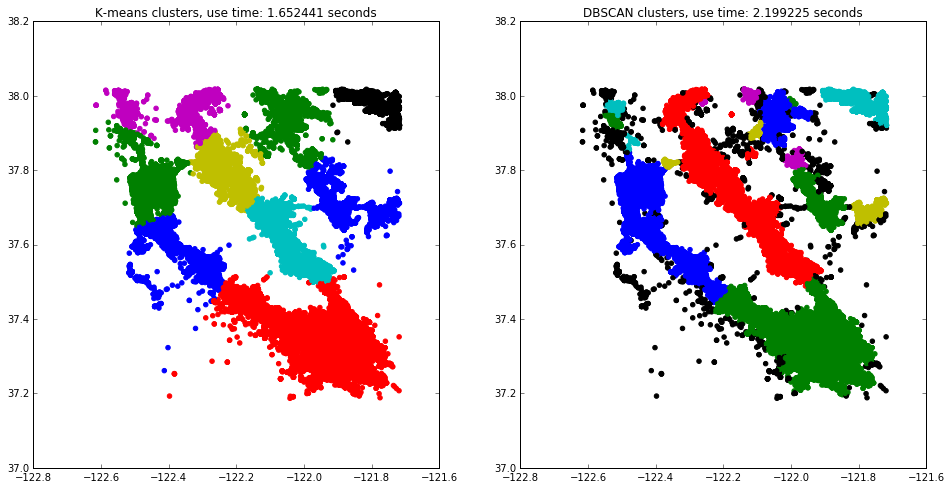

In [91]:
dbscan = DBSCAN(eps=.013, min_samples = 50)
kmeans = KMeans(n_clusters=10)

t0 = time.time()
dbscan_label = dbscan.fit_predict(sample)
dbscan_time = time.time() - t0

t0 = time.time()
kmeans_label = kmeans.fit_predict(sample)
kmeans_time = time.time() - t0

plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.title('K-means clusters, use time: %5f seconds' %kmeans_time)
plt.scatter(sample.lng, sample.lat, color=colors[kmeans_label].tolist())

plt.subplot(122)
plt.title('DBSCAN clusters, use time: %5f seconds' %dbscan_time)
plt.scatter(sample.lng, sample.lat, color=colors[dbscan_label].tolist())

plt.show()

Please note the chosed arugments for both model are quite arbitary here. 

Check this result, we can see K-means did some nearly arbitary clustering that it simply combines from one center and obtains all close points to each other. The cluster almost matches the cities' boundry for most of the parts. However, it did not filter out the noise points, and the cluster can be difficult to explain why these areas are linked to each other. 

On the other hand, DBSCAN clustered the tweets mainly by San Francisco - San Mateo, South Bay, East Bay and out of bay cities. The clusters finish expanding at where there are less tweets. It is more understandable why these clusters are assembled together. At the same time, the cluster filter out the noise tweets, which are mostly send from the highways. However, the clusters are so distributed and some noises are not necessary to have.

Also we should notice that k-means algorithm is faster than the DBSCAN. So when the dataset is convex, we can use k-means to be more efficient.

# 4. Summary

Clustering algorithm might be the easiest machine learning algorithm to implement and understand. However, there are also variations within it. Simple examples would be the difference between the K-means and DBSCAN. It is important to know the charactoristic of them. This is the main purpose of this tutorial.

K-means would be really helpful to do preliminary investigation to the dataset because of its easiness. We can even speed it up by using mini-batch k-means. However, to a denser dataset, the arbitary cluster result may not be what we wanted and may not really meaningful. We also need to decide how many clusters we want before we run the cluster, which might be annoying.

DBSCAN on the other hand, could handle the non-convex data very well and can provide meaningful clusters clearly. Yet it runs slower than k-means and may not really fit every evaluation. 

One should noted that there is no 'best' cluster algorithm but the one fits our requirements the most. Understand the pros and cons to each kind of algorithm, one may have the answers by his own.

# 5. Reference
1. [Wikipedia: DBSCAN](https://en.wikipedia.org/wiki/DBSCAN)
2. [Sklearn Clustering](http://scikit-learn.org/stable/modules/clustering.html#clustering)
3. [Twitter API](https://dev.twitter.com/docs)